# Hand motions classification using non-invasive EEG recordings
### by Cedric Simar and Antoine Passemiers
<hr/>

## Table of content

* [0 - Introduction](#introduction)
  * [0.1. Problem description](#problem-description)


* [1 - Preprocessing](#preprocessing)
  * [1.1. Import useful libraries](#import-libraries)
  * [1.2. Load the data](#load-data)
  * [1.3. Low-pass filtering](#low-pass-filtering)
  * [1.4. Downsampling](#downsampling)


* [2 - A first naive approach: learn from raw EEG samples](#learn-from-raw-data)
  * [2.1. Random Forests (first model)](#random-forests)
    * [2.1.1 VC-dimension of random forests](#random-forests-vc)
    * [2.1.2 Random forest pruning](#random-forest-pruning)
  * [2.2  Logistic regression (second model)](#logistic-regression)
    * [2.2.1 VC dimension of logistic regression](#logistic-regression-vc)


* [3. Riemannian-based kernel trick](#kernel-trick)
  * [3.1. Riemannian-based SVM (fourth model)](#ghmm)
  * [3.2. Linear Discriminant Analysis (fifth model)](#lda)


* [4 - Dealing with non-stationary data](#non-stationary-data)
  * [4.1. Gaussian Hidden Markov Models (third model)](#ghmm)


* [5. ANN, LSTM and weird stuff](#CAFE)


* [X. Bibliography](#bibliography)

## Introduction <a class="anchor" id="introduction"></a>
<hr/>

Note: This notebook has been designed in order to serve several purposes:
1. Introduce different models either that have been successfully applied to EEG-based problems in the past or that are considered by us as being relevant given the nature of the task.
2. Constantly refer to generalization theory while selecting our best models using Structural Risk Minimization (SRM)
3. Present code excerpts used to achieve good performance on the [Kaggle competition](#bib-kaggle) about Grasp-and-Lift EEG detection.

### Problem description <a class="anchor" id="problem-description"></a>

A Brain-Computer Interface (BCI) is a system that establishes a direct communication between a brain and a device without using the neuromuscular pathways. The design and implementation of a BCI system typically require a multidisciplinary approach in order to combine expertise from different fields such as neurophysiology, electronics, signal processing and algorithmics.

Currently, the main field of application of BCI systems is the medical domain. Each year, thousands of patients suffer from severe motor paralysis caused by a trauma or a generative disease. The research objective of the [Kaggle competition](#bib-kaggle) is to develop accurate and robust algorithms that can be integrated in BCI systems to considerably enhance the quality of life of these patients by allowing them to regain some control over their environment. More specifaclly the competition focus on classifying hand motions of 6 different movements: 'HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', and 'BothReleased'. With the help of Machine Learning classification algorithms integrated in a BCI system, the hope is to be able to map brain waves to the desired movement and, eventually control a robotic arm or a prosthesis capable of playing the role of a hand.

### EEG analysis <a class="anchor" id="eeg-analysis"></a>

An electroencephalogram (EEG) uses multiple electrodes (channels) to measure the electrical activity of post-synaptic potentials of cortical neurons located at specific parts of the brain. These electrodes are placed at precise locations on the patient' scalp following the International 10-20 system as illustrated hereunder. 

<figure style="text-align:center;">
  <img src="imgs/EEG_Electrode_Numbering.jpg" style="width:450px;">
  <figcaption> Source: [Kaggle](#bib-kaggle) </figcaption>
</figure>

The purpose of an EEG signal analysis is to use advanced signal processing techniques to extract relevant information about the brain state that are not directly visible in the time domain in order to infer the state of the patient or to diagnose brain-related pathologies. 

### Data <a class="anchor" id="intro-data"></a>

The study and data to support our work was first published in [Nature](#data-nature) and later made publicly available for the purpose of a [Kaggle competition](#bib-kaggle). <br> <br>
The data, totalling 3,936 grasp and lift trials, was collected from twelve participants. "The participant’s task in each trial was to reach for a small object, grasp it using their index finger and thumb, and lift it a few centimetres up in the air, hold it stably for a couple of seconds, and then replace and release the object. The beginning of the reach and the lowering of the object was cued by an LED, otherwise the pace of the task was up to the participant. During all trials, we recorded 32 channels of EEG, 5 channels of EMG from the shoulder, forearm, and hand muscles, the position of the arm, thumb and index finger and the object, and the forces applied to the object by the precision grip. We defined 16 behaviourally relevant events and extracted them for every trial. These event times are available along with the scripts used to generate them and the raw data." [Nature](#data-nature) 

In [1]:
from IPython.display import HTML
url = "https://www.youtube.com/embed/y3_Izuop2gY?rel=0&amp;controls=0&amp;showinfo=0"
HTML('<iframe style="display:block" width="560" height="315" src="%s" frameborder="0" allowfullscreen></iframe>' % url)

When using predictive models with EEG data, it is considered good practice to build patient-specific models rather than one global model for all patients. At first, it would be tempting to aggregate datasets from different patients in order to develop a single model trained with more samples that would therefore be able to better generalize compared to patient-specific models trained with fewer samples. However, this assumption is erroneous and is not considered good practice due to the large divergence between humain brains and patient-specific conditions or mental states that affect the amplitude and rythms of brain waves. For this reason, we chose to use the EEG recordings from the 8 sessions of one patient as the sole source of data for all our models.

### Data exploration <a class="anchor" id="data-exploration"></a>

In order to determine what kind of preprocessing should be applied in order to transform the raw EEG signals into meaningful features that will constitute the input of our classifiers, let's try to visualize and explore our dataset further. <br> <br>
Note: the data from each session of subject 1 (as originally posted on the [Kaggle competition](#bib-kaggle) website) was aggregated in one single compressed file for the use of this notebook. <br> <br>
First, we load the compressed dataset.

In [4]:
import pickle
import gzip

print("Loading compressed dataset... ", end='')
with gzip.GzipFile("./data/sub1_raw.data", 'rb') as handle:
        dataset = pickle.load(handle)
print("done.")

Loading compressed dataset... done.


Now we will explore the data using  [MNE](#mne-website), an open-source Python library for visualizing and analyzing neurophysiological data such as EEG recordings.

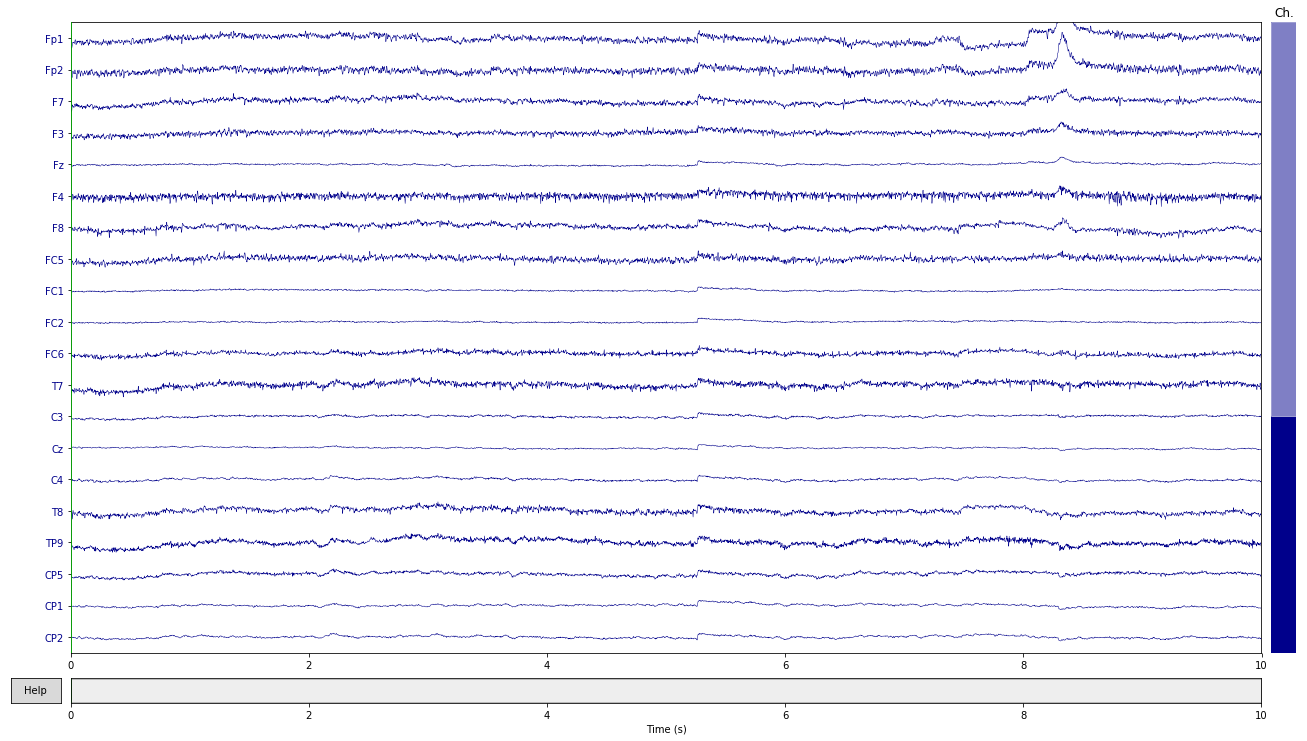

In [17]:
import mne 
import numpy as np

# Electrode names
electrode_names = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

# Label names
event_names = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']

# Sampling frequency
sampling_frequency = 512

# Definition of electrode types
electrode_types = ['eeg' for type in range(len(electrode_names))]

# Creation of the MNE info object
mne_info = mne.create_info(ch_names = electrode_names, sfreq = sampling_frequency, ch_types = electrode_types)

# Selection of the first 10 seconds of the signal
raw_signals = dataset[0][0][:5120, :].T

# Plot the EEG signals
raw = mne.io.RawArray(raw_signals, mne_info, verbose=False);
raw.plot(block=True, scalings=dict(eeg=1e3), color=dict(eeg="darkblue"));

## Preprocessing <a class="anchor" id="preprocessing"></a>
<hr/>

### Import useful libraries <a class="anchor" id="import-libraries"></a>

In [1]:
%load_ext Cython

import cython
import os
import gc
import time
import scipy.linalg
import scipy.signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Load the data <a class="anchor" id="load-data"></a>

TODO Cedric: descriptions (electrodes, multi-labels, échantillonage, tout ça tout ça)



In [9]:
N_PATIENTS = 12
# Feature names
ELECTRODE_NAMES = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
# Label names
EVENT_NAMES = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']


def load_dataset(subject=1, data_dir='', series=range(1,9)):
    data, events = list(), list()
    for series_id, s in enumerate(series):
        print("Load series {0} from patient {1}".format(series_id+1, subject))
        data_filepath = os.path.join(data_dir, "train/subj{0}_series{1}_data.csv".format(subject, s))
        data.append(pd.read_csv(data_filepath, index_col=0).values.astype(np.float))
        events_filepath = os.path.join(data_dir, "train/subj{0}_series{1}_events.csv".format(subject, s))
        events.append(pd.read_csv(events_filepath, index_col=0).values)
    return data, np.concatenate(events, axis=0)

In [3]:
data, events = load_dataset(subject=1, data_dir='data')

Load series 1 from patient 1
Load series 2 from patient 1
Load series 3 from patient 1
Load series 4 from patient 1
Load series 5 from patient 1
Load series 6 from patient 1
Load series 7 from patient 1
Load series 8 from patient 1


### Low-pass filtering <a class="anchor" id="low-pass-filtering"></a>

To avoid creating potential aliasing effects, we apply necessary spectral filters on the raw signals before to downsample them.

In [4]:
class LowPassFilter:
    
    def __init__(self, cutoff_freq, sampling_freq, order=3):
        self.nyquist_freq = sampling_freq / 2.
        bound = cutoff_freq / self.nyquist_freq
        self.b, self.a = scipy.signal.butter(order, bound, btype='lowpass', analog=True)
    
    def filter(self, signal):
        # TODO: does lfiter include future data when filtering current frame?
        return scipy.signal.lfilter(self.b, self.a, signal, axis=0)

In [5]:
Fp1 = [series[:, 0] for series in data] # TODO: electrode 0 or 15
filtered = list()
for cutoff_freq in np.linspace(0, 1, 11)[1:]:
    lowpass = LowPassFilter(cutoff_freq, 500)
    filtered.append(np.concatenate([lowpass.filter(series_fp1) for series_fp1 in Fp1], axis=0)[:, np.newaxis])
filtered = np.concatenate(filtered, axis=1)
X_train_raw = np.concatenate((np.concatenate(data, axis=0), filtered, filtered ** 2), axis=1)

### Downsampling <a class="anchor" id="downsampling"></a>

In [6]:
X_train_downsampled = X_train_raw[::4000]
y_downsampled = events[::4000]

In [7]:
X_train_downsampled = StandardScaler(copy=False).fit_transform(X_train_downsampled)

In [8]:
X_train, X_val = X_train_downsampled[:200], X_train_downsampled[200:]
y_train, y_val = y_downsampled[:200], y_downsampled[200:]

## A first naive approach: learn from EEG samples <a class="anchor" id="learn-from-raw-data"></a>
<hr/>

### Random forests <a class="anchor" id="random-forests"></a>

The classical decision tree algorithms suggest to grow a tree by splitting each node according to the attribute and the split value that jointly minimize a
given cost function. The most commonly used cost functions are the impurity (also called GINI) and the Shannon entropy.
It has been shown that in practice such method may lead to overfitting problems. Instead, the model introduced by [Leo Breiman](#leo-breiman) tends to decrease its generalization error by both combining predictions of independent tree classifiers and maintaining a good individual 
performance for each of them. The random forest algorithm grows individual trees while respecting several properties:

* **Random feature selection**: when splitting a node into two or more children, one must considerate a random subset of attributes used to evaluate the cost function, instead of testing each one of them. The subset size is a hyper-parameter that has to be decided empirically.
* **Bagging**: Bagging (or bootstrap aggregation) is the fact of fitting each tree of the forest with a subset of the original training set with replacement. Random forests use bagging to both minimize the generalization error (this is possible by jointly randomizing feature selection and using bootstrap aggregation/bagging) and making **out-of-bag estimates** for the generalization error. In order to make out-of-bag estimates, a new classifier (called out-of-bag classifier) is build by combining, for each training instance $X_i$, the predictions made by the trees that did not have $X_i$ in their bagging samples. Hence, only a subset of the trees are used when computing the error related to one instance.
* Grown trees are **not pruned** using any post-pruning algorithm.

#### VC-dimension of random forests <a class="anchor" id="random-forests-vc"></a>

Let's denote $s$ the strength of the set of classifiers $\{ h(x, \Theta) \}$, where $h$ is the random forest prediction function,
$x$ is an input instance, and $\Theta$ is the set of parameters of the model (node children, attribute identifiers and split values).

\begin{equation}
  s = \mathop{\mathbb{E}}_{X, Y} P_{\Theta}(h(X, \Theta) = Y) - \max_{j \neq Y} P_{\Theta}(h(X, \Theta) = j)
\end{equation}

The raw margin function is given by:

\begin{equation}
  rmg(\Theta, X, Y) = argmax_{j \neq Y} P_{\Theta} (h(X, \Theta) = j)
\end{equation}

$\bar{\rho}$ is the mean value of the correlation $\rho(\Theta, \Theta')$ between $rmg(\Theta, X, Y)$ and $rmg(\Theta', X, Y)$ 
holding $\Theta, \Theta'$ fixed.

An upper bound for the generalization error is given by the following inequality:

\begin{equation}
  PE^{*} \le \bar{\rho} (1 - s^2) / s^2
\end{equation}

<span style="color:red">TODO: explanations about the formulas, explanation on how to use oob score to estimate the 
generalization error and some python code to compute a bound down below, eventually.</span>

In [14]:
for i in range(6):
    rf = RandomForestClassifier(n_estimators=150, criterion="entropy", oob_score=True)
    rf.fit(X_train, y_train[:, i])
    scores = rf.predict_proba(X_val)[:, 1]
    oob_error = 1. - rf.oob_score_
    print("Fit model %i on %s..." % (i+1, EVENT_NAMES[i]))
    print("\tROC AUC score: %f" % roc_auc_score(y_val[:, i], scores))
    print("\tOut-of-bag error: %f\n" % oob_error)

Fit model 1 on HandStart...
	ROC AUC score: 0.540296
	Out-of-bag error: 0.005000

Fit model 2 on FirstDigitTouch...
	ROC AUC score: 0.659864
	Out-of-bag error: 0.045000

Fit model 3 on BothStartLoadPhase...
	ROC AUC score: 0.662162
	Out-of-bag error: 0.040000

Fit model 4 on LiftOff...
	ROC AUC score: 0.397891
	Out-of-bag error: 0.035000

Fit model 5 on Replace...
	ROC AUC score: 0.551948
	Out-of-bag error: 0.025000

Fit model 6 on BothReleased...
	ROC AUC score: 0.764610
	Out-of-bag error: 0.015000



#### Random forest pruning <a class="anchor" id="random-forest-pruning"></a>

In [ ]:
LEAF_NODE = -1

def post_pruning(tree, min_samples_leaf=1):
    if tree.min_samples_leaf < min_samples_leaf:
        tree.min_samples_leaf = min_samples_leaf
        tree_ = tree.tree_
        for i in range(tree_.node_count):
            n_samples = tree_.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                tree_.children_left[i] = LEAF_NODE
                tree_.children_right[i] = LEAF_NODE

### Logistic regression <a class="anchor" id="logistic-regression"></a>

Logistic regression is a linear model used for classification. Contrary to a linear classifier obtained with the 
Perceptron Learning Algorithm (PLA), it does not output a binary decision given an instance but real-valued predictions that can be viewed as its degree of confidence that the instance belongs to the positive class. These real values are comprised between
0 and 1 and be interpreted as the probability, for each instance, of belonging to the positive class.
Like in linear regression, the input vector $x_i$ of instance $i$ is projected to a scalar $s_i$ called the "signal".

\begin{equation}
  s_i = w^T x_i + c
\end{equation}

where c is the intercept. 
However, nothing ensures that $s_i$ is in $[0, 1]$. Thus, a bounded function called the sigmoid function is 
applied to $s_i$ to fulfill this goal:

\begin{equation}
  h(x_i) = \sigma(s_i) = \frac{1}{1 + e^{-w^T x_i + c}} = \frac{e^{w^T x_i + c}}{1 + e^{w^T x_i + c}}
\end{equation}

This is more convenient because in most machine learning application one wishes to get a warning of the model about prediction
uncertainty. The model ability to make output continuous intermediate values between a 100%-confident positive prediction
and a 100%-confident negative prediction is referred to as soft thresholding.

Let's use the default optimization algorithm from scikit-learn to fit our logistic regressor. The parameters of the model
are penalized by a L2-regularization. Thus, the optimization problem reduces to minimizing the following cost function:

\begin{equation}
  min_w L(w) = min_w \frac{1}{2} w^T w + C \cdot \Sigma_{i=1}^n \log(e^{-y_i (x_i^T w + c)} + 1)
\end{equation}

where parameter $C$ is set to 1 by default, $y_i$ is the ground-truth label $\in \{-1, 1\}$ associated to instance $i$,
and $\frac{1}{2} w^T w$ is the regularization term. This function is better suited for our model than accuracy because it
does take the model uncertainty into account when assigning a loss on a particular instance. The default scikit-learn
optimization algorithm for logistic regression is based on Coordinate Descent (CD). CD can be described in a few steps:

> **1.** Choose an initial weight vector $w^0$. Let $w_i^0$ be the ith component of $w^0$.

> **2.** Repeat until stop condition is met

>>> **3.** Repeat with $i \in \{1, \ldots, n\}$

>>> **4.** $w_i^{k+1} = argmin_{y} \ L(w_1^{k+1}, \ldots, w_{i-1}^{k+1}, y, w_{i+1}^{k}, \ldots, w_{n}^{k})$

>>>This corresponds to a line search along axis $i$.

>> **4.** $k \leftarrow k+1$

In brief, we observe that the algorithm optimizes the cost function according to a single dimension at a time, by performing
a line search along it. This requires, in average, much more step than gradient descent or quasi-newtonian methods since
CD has no information about the direction of the steepest descent.

#### VC dimension of logistic regression <a class="anchor" id="logistic-regression-vc"></a>

<span style="color:red">TODO: I guess that the VC dimension of logreg is the same as the VC dimension
of the linear classifier since they both shatter the data points in the same way, but the VC bounds must be
different since the error metric is different -> do some research.</span>

In [ ]:
for i in range(6):
    logreg = LogisticRegression(C= 1., fit_intercept=True)
    logreg.fit(X_train, y_train[:, i])
    proba = logreg.predict_proba(X_val)[:, 1]

### Extract covariance matrices <a class="anchor" id="extract-cov"></a>

In [7]:
%%cython

import numpy as np
cimport numpy as cnp
cnp.import_array()
import cython

@cython.boundscheck(False)
@cython.overflowcheck(False)
def extract_cov_matrices(cnp.float_t[:, :] data, Py_ssize_t w):
    cdef Py_ssize_t n_features = data.shape[1]
    cdef cnp.float_t[:, :, :] sigmas = np.empty((data.shape[0], n_features, n_features), dtype=np.float)
    cdef cnp.float_t[:] means = np.asarray(np.mean(np.asarray(data)[:w, :], axis=0), dtype=np.float)
    cdef cnp.float_t[:] old_means = np.copy(means)
    cdef cnp.float_t[:, :] last_sigma = np.cov(np.asarray(data)[:w, :].T)
    cdef cnp.float_t c
    np_sigmas = np.asarray(sigmas)
    np_sigmas[:w, :, :] = np.repeat(np.asarray(last_sigma).reshape((1, n_features, n_features), order='C'), w, axis=0)
    cdef Py_ssize_t i, j, a, b
    with nogil:
        for i in range(w, data.shape[0]):
            for a in range(n_features):
                old_means[a] = means[a]
                means[a] += (data[i, a] - data[i-w, a]) / w
            for a in range(n_features):
                for b in range(a+1):
                    c = sigmas[i-1, a, b]
                    c += (data[i, a] * data[i, b] - data[i-w, a] * data[i-w, b]) / w
                    c += old_means[a] * old_means[b] - means[a] * means[b]
                    sigmas[i, a, b] = sigmas[i, b, a] = c
    return np_sigmas

## Riemannian-based kernel trick <a class="anchor" id="kernel-trick"></a>

In [56]:
def hlmap(Cp, sqrtCinv):
    return scipy.linalg.logm(sqrtCinv * Cp * sqrtCinv)

def hemap(Cp, sqrtC):
    return scipy.linalg.expm(sqrtC * Cp * sqrtC)

def project_cov_matrices(X):
    """ X is of shape (n_samples, n_electrodes, n_electrodes) """
    sqrtC = scipy.linalg.sqrtm(X.mean(axis=0))
    sqrtCinv = scipy.linalg.inv(sqrtC)
    return np.asarray([hlmap(h, sqrtCinv) for h in X])

### Riemannian-based Support Vector Machine <a class="anchor" id="svm"></a>

<span style="color:red">TODO</span>

### Linear Discriminant Analysis <a class="anchor" id="lda"></a>

<span style="color:red">TODO</span>

## Dealing with non-stationary processes <a class="anchor" id="non-stationary-data"></a>
<hr/>

### Gaussian Hidden Markov Models (G-HMM) <a class="anchor" id="ghmm"></a>

<span style="color:red">TODO</span>

## Convolutional Neural Network approach

### Settings

In [2]:
import json


class Settings:

    LOADED_FILE = None

    @staticmethod
    def add_attr(name, value):
        """ Statically adds a parameter as an attribute
        to class Settings. All new Settings attributes
        are in capital letters.

        :param name: str
            Name of the new attribute
        :param value: object
            Value of the corresponding hyper-parameter
        """
        name = name.upper()
        setattr(Settings, name, value)

    @staticmethod
    def get_attr(name):
        return getattr(Settings, name.upper())

    @staticmethod
    def load(filepath):
        """ Statically loads the hyper-Settings from a json file

        :param filepath: str
            Path to the json parameter file
        """
        Settings.LOADED_FILE = filepath
        Settings.TO_UPDATE = list()
        with open(filepath, "r") as f:
            data = json.load(f)
            for key in sorted(data.keys()):
                if isinstance(data[key], dict):
                    Settings.add_attr(key, data[key]["value"])
                    
    @staticmethod
    def update():
        if Settings.LOADED_FILE is None:
            print('[Warning] Trying to save Settings but none have been loaded.')
            return
        with open(Settings.LOADED_FILE, "r") as f:
            data = json.load(f)
            for key in data:
                if not isinstance(data[key], dict) or key not in Settings.TO_UPDATE:
                    continue
                if data[key]['value'] != Settings.get_attr(key):
                    data[key]["value"] = Settings.get_attr(key)
        with open(Settings.LOADED_FILE, "w") as f:
            pretty_str = json.dumps(data, indent=4, sort_keys=True)
            f.write(pretty_str)

### Data formating classes

In [3]:

import os
import pandas as pd
import numpy as np


"""
Aggregate the data from csv files of all subjects in one .npy file
"""

class DataAggregator:

    def aggregate(self, csv_data_path, destination_path, purpose = "train"):
        
        assert(purpose in["train", "test"])
        if(not os.path.exists(destination_path)): os.mkdir(destination_path)
        aggregated_file_name = "aggregated_" + purpose + ".npy"
        aggregated_file_path = os.path.join(destination_path, aggregated_file_name)

        if(os.path.exists(aggregated_file_path)):
            print("Aggregated data file already exists: overwrite? (y/n) : ", end='')
            if(input() == 'n'): return()
            
        aggregated_data = []
        aggregated_labels = []

        for subject_id in range(Settings.NUM_SUBJECTS):

            print("Aggregating subject", subject_id+1)

            subject_data = []
            subject_labels = []

            for serie_id in range(Settings.NUM_SERIES):

                # load and append the data into subject_data

                file_name = "subj" + str(subject_id + 1) + "_series" + str(serie_id + 1) + "_data.csv"
                file_path = os.path.join(csv_data_path, file_name)
                serie_data = pd.read_csv(file_path)

                electrodes_names = list(serie_data.columns[1:]) # discard the index column
                subject_data.append(np.array(serie_data[electrodes_names], dtype="float32"))

                if(purpose == "train"):
                        
                    # load and append the labels into subject_labels

                    file_name = "subj" + str(subject_id + 1) + "_series" + str(serie_id + 1) + "_events.csv"
                    file_path = os.path.join(csv_data_path, file_name)
                    serie_labels = pd.read_csv(file_path)

                    events_names = list(serie_labels.columns[1:]) # discard the index column
                    subject_labels.append(np.array(serie_labels[events_names], dtype="float32"))
            
                        
            aggregated_data.append(subject_data)
            aggregated_labels.append(subject_labels)
    

        # save the aggregated data and labels
        np.save(aggregated_file_path, [aggregated_data, aggregated_labels])




class BatchGenerator:

    """
    Generate batches to feed the RCNN
    """

    def __init__(self, file_path):
                
        # to adapt for the 3Gb file

        # load subjects data file(s)
        self.data, self.labels = np.load(file_path)

        # separate training from validation data
        # training data is of shape 6 x 119496 x 32 [series][signal][channel]
        self.training_data = self.data[Settings.SERIES_TRAINING_INDICES]
        self.training_labels = self.labels[Settings.SERIES_TRAINING_INDICES]

        self.validation_data = self.data[Settings.SERIES_VALIDATION_INDICES]
        self.validation_labels = self.labels[Settings.SERIES_VALIDATION_INDICES]

        # get indices of positive and negative data indices in each series
        self.positive_training_indices = [np.where(np.sum(self.training_labels[series], axis=1) > 0)[0] for series in range(len(self.training_data))]
        self.negative_training_indices = [np.where(np.sum(self.training_labels[series], axis=1) == 0)[0] for series in range(len(self.training_data))]


    def get_random_series(self, x):
        return(np.random.randint(len(x)))

    
    def get_random_point(self, series, x):
        return(np.random.randint(Settings.SAMPLE_LENGTH - 1, len(x[series])))
        

    def random_batch(self, purpose, size):

        """
        Generate a batch of fixed size for the training or validation
        We also generate a batch for validation since the number of sample doesn't fit in RAM
        """
        
        batch_data = []
        batch_labels = []

        if purpose == "training":
            x = self.training_data
            y = self.training_labels
        else:
            x = self.validation_data
            y = self.validation_labels

        for _ in range(size):

            series = self.get_random_series(x)
            point = self.get_random_point(series, x)   # time

            # sample is of dimension Settings.SAMPLE_LENGTH x 32
            sample = np.copy(x[series][point - Settings.SAMPLE_LENGTH + 1:point + 1, :])
            
            # per sample per channel mean substraction
            sample -= np.mean(sample, axis=0).reshape((1, Settings.NUM_CHANNELS))

            # reshape sample to 32 x Settings.SAMPLE_LENGTH
            sample = sample.T

            batch_data.append(sample)
            batch_labels.append(y[series][point])

        return((np.asarray(batch_data), np.asarray(batch_labels)))
        



### Decorator functions for Tensorflow

In [4]:
import functools
import tensorflow as tf


def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if no argument is provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

### Convolutional Neural Network

In [5]:
import tensorflow as tf
from tensorflow.python.ops import array_ops as tf_array_ops
from tensorflow.python.ops.init_ops import glorot_uniform_initializer


class CNN:

    def __init__(self, input_ph, labels_ph):

        """
        Simple CNN approach (no recurrence)
        """

        # receiving input placeholder
        self.input = input_ph
        self.labels = labels_ph

        # Network settings
        self.norm_eps = Settings.NORMALIZATION_EPSILON

        # getting the number of hand motions to classify
        self.output_size = Settings.NUM_EVENTS

        # weights and biases dictionary
        self.learning_parameters = {}
        self.layers = {}

        # initialize tensorflow graph
        self.predict
        self.optimize
        self.loss

        # Initialize input placeholder to assign values to weights and biases
        with tf.variable_scope("input_assignment"):

            self.l_param_input = {}
            self.assign_operator = {}
            for variable_name in self.learning_parameters.keys():
                self.l_param_input[variable_name] = tf.placeholder(
                    tf.float32,
                    self.learning_parameters[variable_name].get_shape().as_list(),
                    name=variable_name)

                try:  # If mutable tensor (Variable)
                    self.assign_operator[variable_name] = self.learning_parameters[variable_name].assign(
                        self.l_param_input[variable_name])
                except AttributeError as e:
                    print(e)


    @define_scope
    def predict(self):
        """
        The input to the neural network consists of a 32 channels x SAMPLE_LENGTH signal 
        produced by the preprocessing stage
        """
        # reshape input to 3d tensor [batch, channels, sample length]
        input_layer = tf.reshape(self.input,
                                [-1, Settings.NUM_CHANNELS, Settings.SAMPLE_LENGTH, 1])


        """
        Layer 1: 1D spatial convolution over the channels to condense NUM_CHANNELS to
                 the number of the convolutional filters (thus reducing the input dimenstion)
                 Linear transformation, no activation function used
        """
        conv1 = tf.layers.conv2d(inputs=input_layer, filters=4, kernel_size=[Settings.NUM_CHANNELS, 1],
                                 strides = (1, 1), padding="valid", kernel_initializer=glorot_uniform_initializer(),
                                 activation=None)

        print("conv1 shape: ", conv1.get_shape())
                                 
        """
        Layer 2: 1D temporal convolution over the raw signal of each channel
                 Activation function: ReLu
                 Max pooling 
        """
        conv2 = tf.layers.conv2d(inputs=conv1, filters=32, kernel_size=[1, 9], strides=(1, 1),
                                 padding = "same", kernel_initializer = glorot_uniform_initializer(),
                                 activation = tf.nn.leaky_relu)

        print("conv2 shape: ", conv2.get_shape())

        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(1, 4), strides=(1, 4))
        # no dropout in the first layer

        print("pool2 shape: ", pool2.get_shape())

        """
        Layer 3: Second 1D temporal convolution
                 Activation function: ReLu
                 Max pooling
                 Flatten the output of the max pooling layer to get the input of the FC layer
                 Dropout layer with p = 0.5
        """
        conv3 = tf.layers.conv2d(inputs=pool2, filters=32, kernel_size=[1, 9], strides=(1, 1),
                                 padding = "same", kernel_initializer = glorot_uniform_initializer(),
                                 activation = tf.nn.leaky_relu)
        
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=(1, 4), strides=(1, 4))

        flat3 = tf.layers.flatten(pool3)
        
        drop3 = tf.layers.dropout(inputs=flat3, rate=Settings.DROPOUT_RATE)
        

        print("drop3 shape: ", drop3.get_shape())

        """
        Layers 4 and 5: Standard Fully Connected layers separated by Dropout layers
        """
        fc4 = tf.layers.dense(inputs=drop3, units=1024, activation=tf.nn.relu, use_bias=True,
                              kernel_initializer = glorot_uniform_initializer())
        drop4 = tf.layers.dropout(inputs=fc4, rate=Settings.DROPOUT_RATE)

        fc5 = tf.layers.dense(inputs=drop4, units=1024, activation=tf.nn.relu, use_bias=True,
                              kernel_initializer = glorot_uniform_initializer())
        drop5 = tf.layers.dropout(inputs=fc5, rate=Settings.DROPOUT_RATE)

        
        """
        Layer 6: Output layer
        """
        logits = tf.layers.dense(inputs=drop5, units=Settings.NUM_EVENTS,
                               kernel_initializer = glorot_uniform_initializer(),
                               activation = None)

        # using sigmoid cross entropy (not mutually exclusive) with logits so no need of an
        # activation function at the end of the CNN
        
        return(logits)


    @define_scope
    def predict_proba(self):
        return(tf.sigmoid(self.predict))
    
    @define_scope
    def accuracy(self):
        self.predictions = tf.round(self.predict_proba)
        self.correct_predictions = tf.cast(tf.equal(self.predictions, self.labels), tf.float32)
        return(tf.reduce_mean(self.correct_predictions))

    @define_scope
    def optimize(self):

        self.optimizer = tf.train.MomentumOptimizer(
            learning_rate = Settings.LEARNING_RATE,
            momentum = Settings.MOMENTUM,
            use_nesterov = True
        )
        return(self.optimizer.minimize(self.loss))


    @define_scope
    def loss(self):
        """ Return the mean error """

        self.error = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=self.predict)
        self.mean_error = tf.reduce_mean(self.error, name="mean_error")
        return(self.mean_error)

    
    def get_value(self, var_name, tf_session):
        """
        Return the value of the tf variable named [var_name] if it exists, None otherwise
        """

        if var_name in self.learning_parameters:

            value = tf_session.run(self.learning_parameters[var_name])

        elif var_name in self.layers:

            value = tf_session.run(self.layers[var_name])

        else:
            print("Unknown DQN variable: " + var_name)
            assert(0)  # <3

        return(value)

    def set_value(self, var_name, new_value, tf_session):
        """
        Set the value of the tf variable [var_name] to [new_value]
        """

        if(var_name in self.assign_operator):

            tf_session.run(
                self.assign_operator[var_name], {
                    self.l_param_input[var_name]: new_value})
        else:
            print("Thou shall only assign learning parameters!")

### Main

In [ ]:
from sklearn.metrics import roc_auc_score


# initialize Settings class with json file
Settings.load("./src/settings.json")

# aggregate data per patient
# DataAggregator().aggregate(Settings.TRAIN_DATA_CSV_PATH, Settings.TRAIN_AGG_DATA_PATH, purpose="train")

# initialize a batch generator using the aggregated data
batchGen = BatchGenerator("./data/train/aggregated/sub1_aggregated_train.npy")

# initialize training session variables

input_ph = tf.placeholder(tf.float32, [None, Settings.NUM_CHANNELS, Settings.SAMPLE_LENGTH])
labels_ph = tf.placeholder(tf.float32, [None, Settings.NUM_EVENTS])

nn = CNN(input_ph, labels_ph)

tf_session = tf.Session()
tf_session.run(tf.global_variables_initializer())

# run training session loop
for training_iteration in range(1000):

    # get next training batch
    batch_x, batch_y = batchGen.random_batch("training", Settings.MINIBATCH_SIZE)

    # run a training step
    tf_session.run(nn.optimize, {input_ph: batch_x, labels_ph: batch_y})

    # check the ROC AUC score evolution every x steps
    if training_iteration % 10 == 0:

        # generate a validation batch 
        validation_x, validation_y = batchGen.random_batch("validation", 500)

        print("Predictions:", tf_session.run(nn.predict_proba, {input_ph: validation_x,
                                           labels_ph: validation_y}))

        predicted = tf_session.run(nn.predict_proba, {input_ph: validation_x,
                                           labels_ph: validation_y})

        print("ROC AUC:", roc_auc_score(validation_y.reshape(-1), predicted.reshape(-1)))

## Bibliography <a class="anchor" id="bibliography"></a>
<hr/>

* <span class="anchor" id="bib-riemann">
    [1] Classification of covariance matrices using a Riemannian-based kernel for BCI applications <br>
    Alexandre Barachant, Stéphane Bonnet, Marco Congedo, Christian Jutten <br>
    https://hal.archives-ouvertes.fr/file/index/docid/820475/filename/BARACHANT_Neurocomputing_ForHal.pdf <br>
  </span>
<br>

* <span class="anchor" id="bib-kaggle">
    [2] Grasp-and-Lift EEG Detection Kaggle Competition <br>
    https://www.kaggle.com/c/grasp-and-lift-eeg-detection <br>
  </span>
<br>

* <span class="anchor" id="leo-breiman">
    [3] Random Forests <br>
    Leo Breiman, 2001 <br>
    https://link.springer.com/content/pdf/10.1023%2FA%3A1010933404324.pdf <br>
  </span>
<br>

* <span class="anchor" id="data-nature">
    [4] Multi-channel EEG recordings during 3,936 grasp and lift trials with varying weight and friction <br>
    Matthew D Luciw, Ewa Jarocka, Benoni B Edin, 2014 <br>
    https://www.nature.com/articles/sdata201447.pdf <br>
  </span>
<br>

* <span class="anchor" id="mne-website">
    [5] Open-source Python software for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, and more. <br>
    https://www.martinos.org/mne <br>
  </span>
<br>
